In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
import seaborn as sns
import category_encoders as ce
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier 
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd

In [38]:
df = pd.DataFrame()
for filename in listdir("dataset\\train\\boxes_transcripts_labels"):
    df_temp = pd.read_csv("dataset\\train\\boxes_transcripts_labels\\" + filename, sep = ",", header = None)
    df_temp.columns = ['start_index', 'end_index', 'x_top_left', 'y_top_left', 'x_bottom_right', 'y_bottom_right','transcript','field']
    df = pd.concat([df, df_temp], ignore_index = True)

In [39]:


def Feature_Engineering(df):
    df['x_center'] = df[['x_top_left', 'x_bottom_right']].mean(axis=1)
    df['y_center'] = df[['y_top_left', 'y_bottom_right']].mean(axis=1)
    df['index_len'] = df['end_index'] - df['start_index']

    # Select features and label
    df = df[['start_index', 'end_index', 'x_center', 'y_center', 'index_len', 'field']]

    return df

def X_y_split(df):
    y = df[['field']]
    X = df[['start_index', 'end_index', 'x_center', 'y_center', 'index_len']]
    return X, y

def Hierarchical_Training(df):
    df1 = Feature_Engineering(df)
    df2 = df1.copy()

    # For 1st model, reduce skewness of 'OTHER'
    df1.loc[df1["field"] != "OTHER", "field"] = 'NOT_OTHER'
    rus = RandomUnderSampler(random_state=0, sampling_strategy=0.5)
    X1, y1 = X_y_split(df1)
    resampled_X1, resampled_y1 = rus.fit_resample(X1, y1)
    X_train1, X_valid1, y_train1, y_valid1 = train_test_split(resampled_X1, resampled_y1, test_size=0.2, random_state=0)

    # For 2nd model, exclude 'OTHER'
    df2 = df2.loc[df2['field'] != 'OTHER']
    X2, y2 = X_y_split(df2)
    X_train2, X_valid2, y_train2, y_valid2 = train_test_split(X2, y2, test_size=0.2, random_state=0)

    return X_train1, X_valid1, y_train1, y_valid1, X_train2, X_valid2, y_train2, y_valid2

def Cross_Validation(X, y, model):
    # Create StratifiedKFold object
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    accu_stratified = []
    
    for train_index, test_index in skf.split(X, y):
        X_train_fold, X_test_fold = X.values[train_index], X.values[test_index]
        y_train_fold, y_test_fold = y.values[train_index], y.values[test_index]
        model.fit(X_train_fold, y_train_fold.ravel())
        y_pred_fold = model.predict(X_test_fold)
        accu_stratified.append(accuracy_score(y_test_fold, y_pred_fold))
    
    return accu_stratified


In [40]:
cm_arr = []
X_train1, X_valid1, y_train1, y_valid1, X_train2, X_valid2, y_train2, y_valid2 = Hierarchical_Training(df)
for i in [100,150,200,250,300]:
        model1 = RandomForestClassifier(n_estimators = i)
        model2 = RandomForestClassifier(n_estimators = i)

        model1 = model1.fit(X_train1, y_train1.values.ravel())
        model2 = model2.fit(X_train2, y_train2.values.ravel())

        y_pred1 = model1.predict(X_valid1)
        y_pred2 = model2.predict(X_valid2)

        print('current iteration: ',i)

        acc_other = accuracy_score(y_valid1, y_pred1)
        acc_fine = accuracy_score(y_valid2, y_pred2)

        cm_arr.append([i, acc_other, acc_fine])
        

current iteration:  100
current iteration:  150
current iteration:  200
current iteration:  250
current iteration:  300


In [41]:
cm_arr
x = []
acc_ot = []
acc_fi = []
for i in range(len(cm_arr)):
    x.append(cm_arr[i][0])
    acc_ot.append(cm_arr[i][1])
    acc_fi.append(cm_arr[i][2])


[0.9636102201083951, 0.9637208273421082, 0.963389005640969, 0.9643844707443867, 0.9642738635106736]


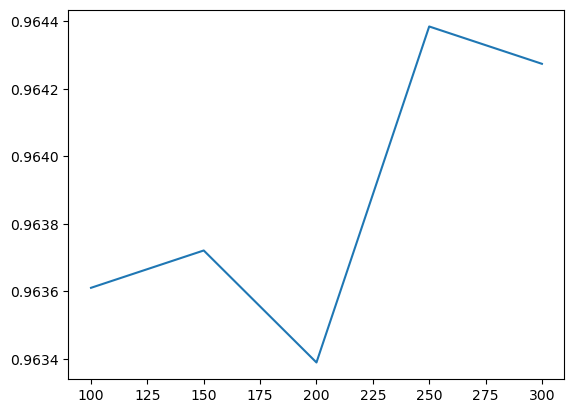

In [36]:
print(acc_ot)
plt.plot(x,acc_ot)

[0.9462508294625083, 0.9499004644990047, 0.9495686794956868, 0.9499004644990047, 0.948905109489051]


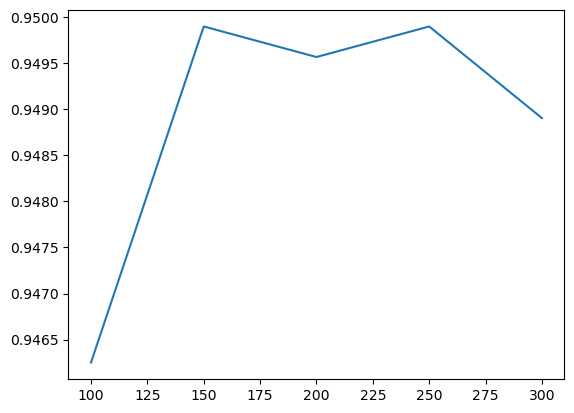

In [30]:
print(acc_fi)
plt.plot(x,acc_fi)